In [ ]:
import os
import json
from collections import Counter
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999

In [ ]:
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, ParameterGrid

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# global variables

BASE_PATH = './drive/My Drive/Kaggle-Stanford-Covid-Vaccine'

In [ ]:
# load data

train = pd.read_json(f"{BASE_PATH}/input_data/train.json", lines=True)
test = pd.read_json(f"{BASE_PATH}/input_data/test.json", lines=True)
sample_submission = pd.read_csv(f'{BASE_PATH}/input_data/sample_submission.csv')

print('Train shapes: ', train.shape)
print('Test shapes: ', test.shape)

Train shapes:  (2400, 19)
Test shapes:  (3634, 7)


In [ ]:
# # add the trimer sequence

# train['sequence_padded'] = train['sequence'].apply(lambda seq: '0'+seq+'0')
# train['sequence_padded'] = train['sequence_padded'].apply(lambda seq: [seq[i-1]+seq[i]+seq[i+1] for i in range(1, len(seq)-1)])

# test['sequence_padded'] = test['sequence'].apply(lambda seq: '0'+seq+'0')
# test['sequence_padded'] = test['sequence_padded'].apply(lambda seq: [seq[i-1]+seq[i]+seq[i+1] for i in range(1, len(seq)-1)])

## Feature Tabulation

In [ ]:
def get_bppm(id_):
    return np.load(f"{BASE_PATH}/input_data/bpps/{id_}.npy")

def get_structure(structure: str):
    pm = np.zeros((len(structure), len(structure)))
    start_token_indices = []
    for i, token in enumerate(structure):
        if token == "(":
            start_token_indices.append(i)
        elif token == ")":
            j = start_token_indices.pop()
            pm[i, j] = 1.0
            pm[j, i] = 1.0
    return pm

def get_bppm_feats(df, base_len=107):
    bppm = np.zeros((df['id'].nunique(), base_len, 4))

    for i, id_ in tqdm(enumerate(df['id'].unique())):
        img = get_bppm(id_)
        maxv = np.max(img, axis=1, keepdims=True)
        argmaxv = np.expand_dims(np.argmax(img, axis=1), axis=1)
        sumv = np.sum(img, axis=1, keepdims=True)
        stdv = np.std(img, axis=1, keepdims=True)
        bppm_stats = np.concatenate([maxv, argmaxv, sumv, stdv], axis=1)[:base_len, :]

        bppm[i] = bppm_stats
    return bppm

In [ ]:
%%time

# tabulate the training bppm features (SN_filter == 1)

bppm_train = get_bppm_feats(train.loc[train.SN_filter == 1])
np.save(f"{BASE_PATH}/processed_data/bppm_train.npy", bppm_train)

1589it [00:02, 677.65it/s]

CPU times: user 1.02 s, sys: 322 ms, total: 1.34 s
Wall time: 2.37 s


In [ ]:
%%time

# tabulate the training bppm features (SN_filter == 0)

bppm_train_0 = get_bppm_feats(train.loc[train.SN_filter == 0])
np.save(f"{BASE_PATH}/processed_data/bppm_train_0.npy", bppm_train_0)

811it [05:45,  2.34it/s]

CPU times: user 1.96 s, sys: 505 ms, total: 2.46 s
Wall time: 5min 45s


In [ ]:
%%time

# tabulate the test bppm features

public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

bppm_public = get_bppm_feats(public_df, 107)
bppm_private = get_bppm_feats(private_df, 130)

np.save(f"{BASE_PATH}/processed_data/bppm_public.npy", bppm_public)
np.save(f"{BASE_PATH}/processed_data/bppm_private.npy", bppm_private)

629it [00:00, 702.91it/s]
3005it [00:05, 595.42it/s]

CPU times: user 2.57 s, sys: 770 ms, total: 3.34 s
Wall time: 6 s


## Ideas to try
- Move dense features to the end (model 31, not used)
- Different hidden sizes for each RNN layer (model 30)
- Conv1D with layer normalization (model 28)
- Revert back to without k-mer (model 27)
- More and more folds = 3*4*2 (model 25)
- More folds = 4*2*2 (model 24)
- Remove SN_filter, but use weighted loss (model 23)
- Encode k-mer of RNA (model 22)
- Augmentation
- Weighted loss = log(1+signal_to_noise+eps) (model21)
- Weighted loss = signal_to_noise (model20)
- GRU (model18, model19)
- Add Conv1D layer (model17, not used >= model 19)
- Different Embedding initialization (model16, not used)
- Add repeats to k-fold (model15)
- More BPPS features (model14)
- Use 4 CV models to ensemble (model13)
- Change metrics back to 5-MCRMSE (model12)
- BPPS (model11)
- Add spatial dropout 1D (Done)
- More features (Done)
- Weighted custom loss (Done)

## Feature Engineering

### 1. Dense feature

In [ ]:
def calculate_base_ratio(df):
    bases = []

    for j in range(len(df)):
        counts = dict(Counter(df.iloc[j]['sequence']))
        len_seq = len(df.iloc[j]['sequence'])
        bases.append((
            counts['A'] / len_seq,
            counts['G'] / len_seq,
            counts['C'] / len_seq,
            counts['U'] / len_seq
        ))
    
    return pd.DataFrame(bases, columns=['A_percent', 'G_percent', 'C_percent', 'U_percent'])

In [ ]:
def calculate_pairs_rate(df):
    pairs_rate = []

    for j in range(len(df)):
        res = dict(Counter(df.iloc[j]['structure']))
        len_half_seq = len(df.iloc[j]['sequence']) / 2
        pairs_rate.append(res['('] / len_half_seq)
    
    return pd.DataFrame(pairs_rate, columns=['pairs_rate'])

In [ ]:
def calculate_all_pairs(df):
    pairs = []
    for j in range(len(df)):
        partners = [-1 for i in range(130)]
        pairs_dict = {}
        queue = []
        for i in range(0, len(df.iloc[j]['structure'])):
            if df.iloc[j]['structure'][i] == '(':
                queue.append(i)
            if df.iloc[j]['structure'][i] == ')':
                first = queue.pop()
                try:
                    pairs_dict[(df.iloc[j]['sequence'][first], df.iloc[j]['sequence'][i])] += 1
                except:
                    pairs_dict[(df.iloc[j]['sequence'][first], df.iloc[j]['sequence'][i])] = 1
                    
                partners[first] = i
                partners[i] = first

        pairs_num = 0
        pairs_unique = [('U', 'G'), ('C', 'G'), ('U', 'A'), ('G', 'C'), ('A', 'U'), ('G', 'U')]
        for item in pairs_dict:
            pairs_num += pairs_dict[item]
        add_tuple = list()
        for item in pairs_unique:
            try:
                add_tuple.append(pairs_dict[item]/pairs_num)
            except:
                add_tuple.append(0)
        pairs.append(add_tuple)
        
    return pd.DataFrame(pairs, columns=['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U'])

In [ ]:
def calculate_loop_type(df):
    loops = []
    for j in range(len(df)):
        counts = dict(Counter(df.iloc[j]['predicted_loop_type']))
        seq_len = len(df.iloc[j]['predicted_loop_type'])
        available = ['E', 'S', 'H', 'B', 'X', 'I', 'M']
        row = []
        for item in available:
            try:
                row.append(counts[item] / seq_len)
            except:
                row.append(0)
        loops.append(row)
        
    return pd.DataFrame(loops, columns=available)

### 2. Sparse feature encoding

In [ ]:
# # get all the unique tokens

# # RNA trimers
# token2int = set()
# for sequence_padded in train['sequence_padded'].values.tolist() + test['sequence_padded'].values.tolist():
#     for trimer in sequence_padded:
#         if trimer not in token2int:
#             token2int.add(trimer)

# # Add single tokens
# token2int = set([x for x in '().ACGUBEHIMSX']) | token2int
# token2int = {x:i for i, x in enumerate(token2int)}

# print(len(token2int))

In [ ]:
# token2int without trimers (14 tokens)

token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
print(len(token2int))

14


In [ ]:
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):

    return np.transpose(
                np.array(df[cols].applymap(lambda seq: [token2int[x] for x in seq]).values.tolist()),
                (0, 2, 1)
            )

### 3. BPPM features

In [ ]:
# load tabulated features

bppm_train = np.load(f"{BASE_PATH}/processed_data/bppm_train.npy")
bppm_train_0 = np.load(f"{BASE_PATH}/processed_data/bppm_train_0.npy")
bppm_public = np.load(f"{BASE_PATH}/processed_data/bppm_public.npy")
bppm_private = np.load(f"{BASE_PATH}/processed_data/bppm_private.npy")

print(bppm_train.shape, bppm_train_0.shape, bppm_public.shape, bppm_private.shape)

(1589, 107, 4) (811, 107, 4) (629, 107, 4) (3005, 130, 4)


### 4. Combine all the above

In [ ]:
def calculate_all_features(df, np_bppm):

    # sparse features
    sparse_features = preprocess_inputs(df)
    seq_len = sparse_features.shape[1]

    # dense features
    bases = calculate_base_ratio(df)
    pairs_rate = calculate_pairs_rate(df)
    all_pairs = calculate_all_pairs(df)
    loops = calculate_loop_type(df)
    dense_features = np.array(pd.concat([bases, all_pairs, loops, pairs_rate], axis=1))
    dense_features = np.concatenate([np.expand_dims(dense_features, axis=1)]*seq_len, axis=1)

    # bppm features
    bppm_features = np_bppm

    return np.concatenate((sparse_features, dense_features, bppm_features), axis=-1)

In [ ]:
%%time

# process features

train_inputs_1 = calculate_all_features(train.loc[train['SN_filter'] == 1], bppm_train)
train_inputs_0 = calculate_all_features(train.loc[train['SN_filter'] == 0], bppm_train_0)

print(train_inputs_1.shape, train_inputs_0.shape)

(1589, 107, 25) (811, 107, 25)
CPU times: user 1min 35s, sys: 0 ns, total: 1min 35s
Wall time: 1min 35s


In [ ]:
# process labels

target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']

train_labels_1 = np.array(train.loc[train['SN_filter'] == 1][target_cols].values.tolist()).transpose((0, 2, 1))
train_labels_0 = np.array(train.loc[train['SN_filter'] == 0][target_cols].values.tolist()).transpose((0, 2, 1))

In [ ]:
# process weights

eps = 0.104
train_weights_1 = np.log1p(np.array(train.loc[train['SN_filter'] == 1]['signal_to_noise'].values + eps))
train_weights_1 = np.expand_dims(np.column_stack([train_weights_1]*train_labels_1.shape[1]), axis=2)

train_weights_0 = np.log1p(np.array(train.loc[train['SN_filter'] == 0]['signal_to_noise'].values + eps))
train_weights_0 = np.expand_dims(np.column_stack([train_weights_0]*train_labels_0.shape[1]), axis=2)

print(train_weights_1.shape, train_weights_0.shape)

(1589, 68, 1) (811, 68, 1)


In [ ]:
print(train_inputs_1.shape, train_inputs_0.shape, train_labels_1.shape, train_labels_0.shape, train_weights_1.shape, train_weights_0.shape)

(1589, 107, 25) (811, 107, 25) (1589, 68, 5) (811, 68, 5) (1589, 68, 1) (811, 68, 1)


## Build the model

In [ ]:
class RNADataset(Dataset):
    def __init__(self, X, Y, weights):
        self.X = X
        self.y = Y
        self.weights = weights
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.weights[idx]

In [ ]:
# global constants

TOKEN_SIZE = 14
INPUT_SIZE = 3
DENSE_SIZE = 22
OUTPUT_SIZE = 5

In [ ]:
class OpenVaccineModel(nn.Module):
    def __init__(self, embedding_size, spatial_dropout, rnn_params):
        super().__init__()

        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(TOKEN_SIZE, embedding_size)
        #nn.init.uniform_(self.embeddings.weight, -0.05, 0.05)

        self.dropout2d = nn.Dropout2d(spatial_dropout)

        self.rnn_layers = []
        input_dim = INPUT_SIZE*embedding_size+DENSE_SIZE

        for param_dict in rnn_params:
            if param_dict['rnn_type'] == 'LSTM':
                rnn_layer = nn.LSTM(
                    input_dim,
                    param_dict['hidden_size'],
                    batch_first=True,
                    dropout=param_dict['rnn_dropout'],
                    bidirectional=True
                )
            elif param_dict['rnn_type'] == 'GRU':
                rnn_layer = nn.GRU(
                    input_dim,
                    param_dict['hidden_size'],
                    batch_first=True,
                    dropout=param_dict['rnn_dropout'],
                    bidirectional=True
                )
            else:
                print("The RNN type input is not supported. Choose between LSTM and GRU")
            
            self.rnn_layers.append(rnn_layer)
            input_dim = 2*param_dict['hidden_size']

        self.rnn_layers = nn.ModuleList(self.rnn_layers)

        # if rnn_type == 'LSTM':
        #     self.rnn = nn.LSTM(
        #         INPUT_SIZE*embedding_size+DENSE_SIZE,
        #         hidden_size,
        #         num_layers,
        #         batch_first=True,
        #         dropout=rnn_dropout,
        #         bidirectional=True
        #     )
        # elif rnn_type == 'GRU':
        #     self.rnn = nn.GRU(
        #         INPUT_SIZE*embedding_size+DENSE_SIZE,
        #         hidden_size,
        #         num_layers,
        #         batch_first=True,
        #         dropout=rnn_dropout,
        #         bidirectional=True
        #     )
        # else:
        #     print("The RNN type input is not supported. Choose between LSTM and GRU")

        self.linear = nn.Linear(2*param_dict['hidden_size'], OUTPUT_SIZE)

    def forward(self, x, pred_len=68):
        # x = (batch_size, seq_len, input_size+dense_size)
        x_sparse = x[:,:,:INPUT_SIZE].long()
        x_dense = x[:,:,INPUT_SIZE:]

        # embeds = (batch_size, seq_len, input_size*embedding_size)
        embeds = self.embeddings(x_sparse)
        embeds = torch.reshape(embeds, (embeds.shape[0], embeds.shape[1], -1))

        # spatial dropout 1d
        # dropout_output = (batch_size, seq_len, input_size*embedding_size)
        dropout_output = self.dropout2d(embeds.permute(0, 2, 1)).permute(0, 2, 1)

        # rnn_input = (batch_size, seq_len, input_size*embedding_size+dense_size)
        rnn_input = torch.cat((dropout_output, x_dense), -1).float()

        # rnn_output = (batch_size, seq_len, hidden_size)
        #rnn_out, hidden = self.rnn(rnn_input)
        for i in range(len(self.rnn_layers)):
            rnn_out, hidden = self.rnn_layers[i](rnn_input)
            rnn_input = rnn_out

        # truncated = (batch_size, pred_len, input_size*embedding_size+dense_size)
        # prediction = (batch_size, seq_len, output_size)
        truncated = rnn_out[:, :pred_len, :]
        predictions = self.linear(truncated)

        return predictions

In [ ]:
# MCRMSE with sample weights

def MCRMSE(preds, labels, weights, num_scored=5):
    score = 0
    for i in range(num_scored):
        score += torch.sqrt((weights[:,:,0] * (preds[:,:,i] - labels[:,:,i])**2).sum() / weights.sum()) / num_scored

    return score

In [ ]:
# test model output dimensions

rnn_params = [
    {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2},
    {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2},
    {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2},
    {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.0},
]

model = OpenVaccineModel(
    embedding_size=64,
    spatial_dropout=0.4,
    rnn_params=rnn_params
).to(device)

inputs = torch.tensor(train_inputs_1[0:32]).to(device)
weights = torch.tensor(train_weights_1[0:32]).to(device)

with torch.no_grad():
    outputs = model(inputs)
    print(outputs.shape)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


torch.Size([32, 68, 5])


In [ ]:
# number of parameters in this model

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

5700997


## Train the model

In [ ]:
def train_model_cross_val(params, train_data_1, train_data_0, num_fold, n_repeats):
    """ train the model using kfold cross validation """

    # unpack the input
    train_inputs_1, train_labels_1, train_weights_1 = train_data_1
    train_inputs_0, train_labels_0, train_weights_0 = train_data_0

    models = []

    # # get a string containing all the parameters as the folder name to store the log/model/file
    # all_params = list(params.values())
    # all_params_str = "_".join([str(x) for x in all_params])
    all_params_str = 'training_log'
    if not os.path.exists("./{}".format(all_params_str)):
        os.makedirs("./{}".format(all_params_str))
    
    # split the data into k-fold
    #kfold = KFold(num_fold, shuffle=True, random_state=42)
    kfold = RepeatedKFold(num_fold, n_repeats, random_state=42)
    
    loss_oob = np.zeros((num_fold*n_repeats, 1))

    # k-fold cross validation training
    for k, ((train_index_1, val_index), (train_index_0, _)) in enumerate(zip(kfold.split(train_inputs_1), kfold.split(train_inputs_0))):

        # training set = the training fold in both SN_filter == 0 and SN_filter == 1
        train_inputs = np.concatenate((train_inputs_1[train_index_1], train_inputs_0[train_index_0]), axis=0)
        train_labels = np.concatenate((train_labels_1[train_index_1], train_labels_0[train_index_0]), axis=0)
        train_weights = np.concatenate((train_weights_1[train_index_1], train_weights_0[train_index_0]), axis=0)

        # train_inputs = train_inputs_1[train_index_1]
        # train_labels = train_labels_1[train_index_1]
        # train_weights = train_weights_1[train_index_1]

        train_ds = RNADataset(train_inputs, train_labels, train_weights)
        train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

        # validation set = the validation fold in SN_filter == 1 only
        val_ds = RNADataset(train_inputs_1[val_index], train_labels_1[val_index], train_weights_1[val_index])
        val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

        # initialize the model
        model = OpenVaccineModel(
            embedding_size=params['embedding_size'],
            spatial_dropout=params['spatial_dropout'],
            rnn_params=params['rnn_params']
        ).to(device)

        # initialize the otpimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

        # initialize the log file
        log_file = open("./{}/log_{}.csv".format(all_params_str, k), 'w')
        log_file.write('epoch,loss_train,loss_val\n')

        # start the training
        for i in tqdm(range(params['epochs'])):
        #for i in range(params['epochs']):

            # training
            model.train()
            sum_loss, num_samples = 0.0, 0
            for x, y, weights in train_dl:
                x, y, weights = x.to(device), y.to(device), weights.to(device)
                y_pred = model(x)
                optimizer.zero_grad()
                loss = MCRMSE(y_pred, y, weights)
                loss.backward()
                optimizer.step()
                sum_loss += loss.item()*y.shape[0]
                num_samples += y.shape[0]
            train_loss = sum_loss/num_samples

            # evaluation
            model.eval()
            sum_loss, num_samples = 0.0, 0

            for x, y, weights in val_dl:
                x, y, weights = x.to(device), y.to(device), weights.to(device)
                y_pred = model(x)
                loss = MCRMSE(y_pred, y, weights)
                sum_loss += loss.item()*y.shape[0]
                num_samples += y.shape[0]
            val_loss = sum_loss/num_samples

            # write stats to log
            log_file.write('{},{:.4f},{:.4f}\n'.format(i, train_loss, val_loss))
            #print("Fold {}, Epoch {}, Train loss {:.5f}, Validation loss {:.5f}".format(k, i, train_loss, val_loss))
            
        log_file.close()

        # get final validation set stats
        loss_oob[k] = val_loss

        # save the model
        models.append(model)

    return models, loss_oob

In [ ]:
def visualize_learning_curve(params, num_fold):

    all_params = list(params.values())
    all_params_str = "_".join([str(x) for x in all_params])

    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    if num_fold == -1:
        df = pd.read_csv('./{}/log_final.csv'.format(all_params_str))
        df.plot(x='epoch', y='loss_train', ax=ax, color='red');
    else:
        for k in range(num_fold):
            df = pd.read_csv('./{}/log_{}.csv'.format(all_params_str, k))
            df.plot(x='epoch', y='loss_train', ax=ax, color='red');
            df.plot(x='epoch', y='loss_val', ax=ax, color='blue');

In [ ]:
# hyperparameters

rnn_params1 = [
    {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2},
    {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4},
    {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0},
]

rnn_params2 = [
    {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2},
    {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4},
    {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0},
]

rnn_params3 = [
    {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2},
    {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4},
    {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0},
]

rnn_params4 = [
    {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2},
    {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4},
    {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0},
]

rnn_params5 = [
    {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2},
    {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4},
    {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0},
]

rnn_params6 = [
    {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2},
    {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4},
    {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0},
]

rnn_params7 = [
    {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2},
    {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4},
    {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0},
]

rnn_params8 = [
    {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2},
    {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4},
    {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0},
]

params_grid = {
    'embedding_size': [64],
    'spatial_dropout': [0.4],
    'learning_rate': [0.001],
    'epochs': [50],
    'rnn_params': [rnn_params1, rnn_params2, rnn_params3, rnn_params4, rnn_params5, rnn_params6, rnn_params7, rnn_params8]
}

num_fold = 4
n_repeats = 2

In [ ]:
# whether to save all the models in the grid for ensembling

accumulate_models = True

In [ ]:
models_ensemble = []
df_params = pd.DataFrame(columns=list(params_grid.keys()) + ['rmse_mean', 'rmse_std'])

for params in ParameterGrid(params_grid):
    print(params)

    # train the model using k-fold cross validation
    models, rmse_oob = train_model_cross_val(
        params,
        (train_inputs_1, train_labels_1, train_weights_1),
        (train_inputs_0, train_labels_0, train_weights_0),
        num_fold,
        n_repeats
    )

    # compute mean and std of the k-fold results
    params['rmse_mean'], params['rmse_std'] = np.mean(rmse_oob), np.std(rmse_oob)
    print("Average RMSE from {}-fold validation is {:.5f} +/- {:.5f}".format(num_fold, params['rmse_mean'], params['rmse_std']))

    # append to the master parameter table
    df_params = df_params.append(params, ignore_index=True)

    # save the parameter table
    df_params.to_csv('{}/df_params.csv'.format(BASE_PATH), index=False)

    # save models to the ensemble
    if accumulate_models:
        models_ensemble.extend(models)
    else:
        models_ensemble = models

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'rnn_params': [{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0}], 'spatial_dropout': 0.4}


  0%|          | 0/50 [00:00<?, ?it/s]

Average RMSE from 4-fold validation is 0.23418 +/- 0.00248
{'embedding_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'rnn_params': [{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}], 'spatial_dropout': 0.4}


  0%|          | 0/50 [00:00<?, ?it/s]

Average RMSE from 4-fold validation is 0.23437 +/- 0.00424
{'embedding_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'rnn_params': [{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0}], 'spatial_dropout': 0.4}


  0%|          | 0/50 [00:00<?, ?it/s]

Average RMSE from 4-fold validation is 0.23504 +/- 0.00291
{'embedding_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'rnn_params': [{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0}], 'spatial_dropout': 0.4}


  0%|          | 0/50 [00:00<?, ?it/s]

Average RMSE from 4-fold validation is 0.23401 +/- 0.00318
{'embedding_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'rnn_params': [{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}], 'spatial_dropout': 0.4}


  0%|          | 0/50 [00:00<?, ?it/s]

Average RMSE from 4-fold validation is 0.23421 +/- 0.00472
{'embedding_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'rnn_params': [{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}], 'spatial_dropout': 0.4}


  0%|          | 0/50 [00:00<?, ?it/s]

Average RMSE from 4-fold validation is 0.23400 +/- 0.00342
{'embedding_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'rnn_params': [{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0}], 'spatial_dropout': 0.4}


  0%|          | 0/50 [00:00<?, ?it/s]

Average RMSE from 4-fold validation is 0.23219 +/- 0.00235
{'embedding_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'rnn_params': [{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}], 'spatial_dropout': 0.4}


100%|██████████| 50/50 [01:04<00:00,  1.30s/it]

Average RMSE from 4-fold validation is 0.23159 +/- 0.00210


In [ ]:
# 2020-09-30
# different hidden sizes

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
7,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.231589,0.002103
6,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.232195,0.002349
5,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.234000,0.003420
3,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.234011,0.003182
0,64,0.4,0.001,50,"[{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.234181,0.002479
4,64,0.4,0.001,50,"[{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.234211,0.004723
1,64,0.4,0.001,50,"[{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.234366,0.004237
2,64,0.4,0.001,50,"[{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.235042,0.002907


0.23369949778249013

In [ ]:
# 2020-09-30
# different hidden sizes, SN_filter == 1

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
1,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.233044,0.002788
0,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.233281,0.002648
2,64,0.4,0.001,50,"[{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.234077,0.003788


0.23346734891032397

In [ ]:
# 2020-09-30
# different hidden sizes, SN_filter == 1

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
1,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 512, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.227997,0.002548
0,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 512, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.228741,0.003002
2,64,0.4,0.001,50,"[{'rnn_type': 'GRU', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 512, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.229266,0.002470


0.22866812591768104

In [ ]:
# 2020-09-30
# different hidden sizes, SN_filter == 1

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
1,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 512, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.227409,0.001786
2,64,0.4,0.001,50,"[{'rnn_type': 'GRU', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 512, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.228813,0.001910
0,64,0.4,0.001,50,"[{'rnn_type': 'GRU', 'hidden_size': 384, 'rnn_dropout': 0.4}, {'rnn_type': 'GRU', 'hidden_size': 512, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.230579,0.002635


0.2289335398927789

In [ ]:
# 2020-09-30
# different hidden sizes, SN_filter == 1

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
1,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 512, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.227082,0.001730
0,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 512, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.227743,0.001227
2,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.4}, {'rnn_type': 'LSTM', 'hidden_size': 512, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.228081,0.001410


0.22763566753464426

In [ ]:
# 2020-09-30
# different hidden sizes, SN_filter == 1

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
1,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 512, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.0}]",0.227220,0.001445
2,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 512, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.0}]",0.227990,0.001772
0,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.0}]",0.228553,0.001616


0.2279206863714456

In [ ]:
# 2020-09-30
# different hidden sizes, SN_filter == 1

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
1,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.0}]",0.228211,0.001290
0,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}]",0.228463,0.001743
2,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}]",0.228934,0.001185


0.22853603761320307

In [ ]:
# 2020-09-30
# different hidden sizes, SN_filter == 1

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
2,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}]",0.229438,0.001503
3,64,0.4,0.001,50,"[{'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'GRU', 'hidden_size': 192, 'rnn_dropout': 0.2}]",0.229489,0.002440
1,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 128, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.0}]",0.229813,0.002641
0,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 128, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}]",0.230659,0.002525


0.22984991824569115

In [ ]:
# 2020-09-29
# different hidden sizes

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
1,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 128, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.0}]",0.23414,0.003380
0,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}]",0.23463,0.002452
2,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 128, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}]",0.23477,0.001716


0.2345129077250678

In [ ]:
# 2020-09-29
# different hidden sizes

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,embedding_size,spatial_dropout,learning_rate,epochs,rnn_params,rmse_mean,rmse_std
0,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}]",0.232661,0.002259
2,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 128, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 192, 'rnn_dropout': 0.2}]",0.233638,0.002423
1,64,0.4,0.001,50,"[{'rnn_type': 'LSTM', 'hidden_size': 128, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 384, 'rnn_dropout': 0.2}, {'rnn_type': 'LSTM', 'hidden_size': 256, 'rnn_dropout': 0.0}]",0.234843,0.003797


0.23371371432338314

In [ ]:
# 2020-09-28
# Back to without Conv1D. use k-fold on SN_filter == 0 set as well

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,GRU,64,256,4,0.4,0.2,0.001,60,0.224512,0.003098
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.224753,0.003907


0.22463228432741184

In [ ]:
# 2020-09-28
# Conv1D + LayerNorm, 4*1*1

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,num_channels,kernel_size,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,LSTM,64,256,4,32,3,0.4,0.2,0.001,60,0.225153,0.002523


0.22515317154259773

In [ ]:
# 2020-09-28
# Revert back to without trimer, 4*2*2

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.225135,0.003444
0,GRU,64,256,4,0.4,0.2,0.001,60,0.225152,0.004238


0.2251434601228035

In [ ]:
# 2020-09-27
# Remove SN_filter, 4*4*2

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.224889,0.003519
0,GRU,64,256,4,0.4,0.2,0.001,60,0.225046,0.002788


0.22496744846415095

In [ ]:
# 2020-09-27
# Remove SN_filter, 3*4*2

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.227197,0.003325
0,GRU,64,256,4,0.4,0.2,0.001,60,0.228425,0.005527


0.22781111175232027

In [ ]:
# 2020-09-27
# Remove SN_filter, num_repeats = 2

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.224666,0.003856
0,GRU,64,256,4,0.4,0.2,0.001,60,0.224709,0.003142


0.22468721468199887

In [ ]:
# 2020-09-27
# Remove SN_filter

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,GRU,64,256,4,0.4,0.2,0.001,60,0.225000,0.001909
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.226079,0.002170


0.22553964738231946

In [ ]:
# 2020-09-27
# Weights = log1p(signal_to_noise) + Trimer encoding

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,GRU,64,256,4,0.4,0.2,0.001,60,0.223179,0.001602
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.223209,0.002049


0.22319385413698314

In [ ]:
# 2020-09-27
# Weights = signal_to_noise + Trimer encoding

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
7,LSTM,64,256,4,0.4,0.2,0.001,60,0.217408,0.001857
0,LSTM,48,256,3,0.3,0.2,0.001,60,0.217608,0.001614
3,LSTM,48,256,4,0.4,0.2,0.001,60,0.217906,0.002038
1,LSTM,48,256,3,0.4,0.2,0.001,60,0.218611,0.002338
6,LSTM,64,256,4,0.3,0.2,0.001,60,0.218659,0.001641
5,LSTM,64,256,3,0.4,0.2,0.001,60,0.218993,0.002491
4,LSTM,64,256,3,0.3,0.2,0.001,60,0.219200,0.003093
2,LSTM,48,256,4,0.3,0.2,0.001,60,0.220428,0.001829


0.2186017526949037

In [ ]:
# 2020-09-26
# Weights = signal_to_noise, more and more and more and more hyperparameters

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
2,LSTM,64,256,4,0.4,0.2,0.0005,150,0.219068,0.001795
1,LSTM,64,256,4,0.4,0.2,0.0005,100,0.219307,0.003017
0,LSTM,64,256,4,0.4,0.2,0.0005,50,0.221206,0.001499


0.21986027511806006

In [ ]:
# 2020-09-26
# Weights = signal_to_noise, more and more and more hyperparameters

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
3,LSTM,32,256,4,0.4,0.2,0.001,60,0.217915,0.001362
0,GRU,32,256,4,0.2,0.2,0.001,60,0.217988,0.001612
2,LSTM,32,256,4,0.2,0.2,0.001,60,0.219014,0.001227
1,GRU,32,256,4,0.4,0.2,0.001,60,0.219222,0.001794


0.21853456479118682

In [ ]:
# 2020-09-26
# Weights = signal_to_noise, more and more hyperparameters

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
3,LSTM,64,256,4,0.6,0.2,0.001,60,0.217244,0.002323
2,LSTM,64,256,4,0.4,0.2,0.001,60,0.217546,0.002384
0,GRU,64,256,4,0.4,0.2,0.001,60,0.218111,0.002072
1,GRU,64,256,4,0.6,0.2,0.001,60,0.218489,0.002098
4,GRU,128,256,4,0.4,0.2,0.001,60,0.218698,0.002420
7,LSTM,128,256,4,0.6,0.2,0.001,60,0.219743,0.001763
5,GRU,128,256,4,0.6,0.2,0.001,60,0.220304,0.002875
6,LSTM,128,256,4,0.4,0.2,0.001,60,0.220574,0.003492


0.21883863406786697

In [ ]:
# 2020-09-26
# Weights = signal_to_noise, more hyperparameters

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
4,GRU,64,256,4,0.4,0.2,0.001,60,0.217634,0.001464
7,LSTM,64,256,4,0.4,0.4,0.001,60,0.218648,0.001381
5,LSTM,64,256,4,0.4,0.2,0.001,60,0.218707,0.001596
6,GRU,64,256,4,0.4,0.4,0.001,60,0.220559,0.001362
0,GRU,64,128,4,0.4,0.2,0.001,60,0.221489,0.001054
1,LSTM,64,128,4,0.4,0.2,0.001,60,0.222545,0.001533
3,LSTM,64,128,4,0.4,0.4,0.001,60,0.225078,0.001795
2,GRU,64,128,4,0.4,0.4,0.001,60,0.227966,0.001627


0.22157848419503431

In [ ]:
# 2020-09-26
# Weights = log1p(signal_to_noise+eps)

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,GRU,64,256,4,0.4,0.2,0.001,60,0.222556,0.001509
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.223507,0.002049


0.22303138577869464

In [ ]:
# 2020-09-26
# Weights = signal_to_noise

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,GRU,64,256,4,0.4,0.2,0.001,60,0.217555,0.001353
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.217671,0.001797


0.21761331058951563

In [ ]:
# 2020-09-26
# GRU + LSTM ensembling, without Conv1D

display(df_params.sort_values(by="rmse_mean"))
df_params['rmse_mean'].mean()

,rnn_type,embedding_size,hidden_size,num_layers,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
1,LSTM,64,256,4,0.4,0.2,0.001,60,0.230767,0.001997
0,GRU,64,256,4,0.4,0.2,0.001,60,0.231425,0.001630


0.23109613672590687

In [ ]:
# 2020-09-26
# Conv1D and GRU + LSTM ensembling

df_params.sort_values(by="rmse_mean")

,rnn_type,embedding_size,hidden_size,num_layers,num_channels,kernel_size,spatial_dropout,rnn_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,GRU,64,256,4,32,5,0.4,0.2,0.001,60,0.231394,0.001149
1,LSTM,64,256,4,32,5,0.4,0.2,0.001,60,0.232915,0.002180


In [ ]:
# 2020-09-26
# Add Conv1D - part3

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,num_channels,kernel_size,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,64.0,256.0,4.0,32.0,5.0,0.4,0.2,0.001,60.0,0.231898,0.003361


In [ ]:
# 2020-09-25
# Add Conv1D - part2

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,num_channels,kernel_size,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
7,64.0,256.0,4.0,32.0,5.0,0.4,0.2,0.001,60.0,0.231708,0.002909
5,64.0,256.0,4.0,16.0,5.0,0.4,0.2,0.001,60.0,0.232168,0.002165
3,64.0,256.0,4.0,32.0,5.0,0.4,0.2,0.001,40.0,0.233105,0.001773
2,64.0,256.0,4.0,32.0,5.0,0.2,0.2,0.001,40.0,0.233234,0.002067
1,64.0,256.0,4.0,16.0,5.0,0.4,0.2,0.001,40.0,0.233703,0.001300
6,64.0,256.0,4.0,32.0,5.0,0.2,0.2,0.001,60.0,0.233741,0.001372
4,64.0,256.0,4.0,16.0,5.0,0.2,0.2,0.001,60.0,0.233909,0.002229
0,64.0,256.0,4.0,16.0,5.0,0.2,0.2,0.001,40.0,0.233979,0.001877


In [ ]:
# 2020-09-25
# Add Conv1D - part1

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,num_channels,kernel_size,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
1,64.0,256.0,4.0,32.0,5.0,0.2,0.2,0.001,40.0,0.234272,0.002620
0,64.0,256.0,4.0,16.0,5.0,0.2,0.2,0.001,40.0,0.234349,0.001691


In [ ]:
# 2020-09-25
# embedding initialization to uniform (-0.05, 0.05)
# not used

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,64.0,256.0,4.0,0.2,0.2,0.001,80.0,0.235926,0.003315


In [ ]:
# 2020-09-25
# embedding initialization to uniform (-0.05, 0.05)

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,64.0,256.0,4.0,0.2,0.2,0.001,40.0,0.236715,0.002978


In [ ]:
# 2020-09-20
# + 4*2 fold

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,64.0,256.0,4.0,0.2,0.2,0.001,40.0,0.23183,0.003274


In [ ]:
# 2020-09-20
# with 4 bppm features + 5-MCRMSE

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,64.0,256.0,4.0,0.2,0.2,0.001,40.0,0.231412,0.000868


In [ ]:
# 2020-09-20
# with 1 bppm feature + 5-MCRMSE

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,64.0,256.0,4.0,0.2,0.2,0.001,70.0,0.231507,0.002734


In [ ]:
# 2020-09-20
# with bppm features

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
0,64.0,256.0,4.0,0.2,0.2,0.001,100.0,0.233082,0.001523


In [ ]:
# 2020-09-19

df_params.sort_values(by="rmse_mean")

,embedding_size,hidden_size,num_layers,spatial_dropout,lstm_dropout,learning_rate,epochs,rmse_mean,rmse_std
4,64.0,256.0,4.0,0.2,0.2,0.001,50.0,0.236092,0.001399
6,64.0,256.0,8.0,0.2,0.2,0.001,50.0,0.236413,0.000653
5,64.0,256.0,4.0,0.4,0.2,0.001,50.0,0.236426,0.001543
13,128.0,256.0,4.0,0.4,0.2,0.001,50.0,0.236534,0.001728
14,128.0,256.0,8.0,0.2,0.2,0.001,50.0,0.237642,0.000837
15,128.0,256.0,8.0,0.4,0.2,0.001,50.0,0.237934,0.002879
12,128.0,256.0,4.0,0.2,0.2,0.001,50.0,0.238486,0.002298
7,64.0,256.0,8.0,0.4,0.2,0.001,50.0,0.238920,0.001074
8,128.0,128.0,4.0,0.2,0.2,0.001,50.0,0.240214,0.002991
9,128.0,128.0,4.0,0.4,0.2,0.001,50.0,0.240463,0.001015


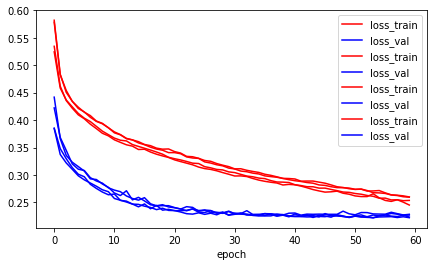

In [ ]:
# visualize the learning curve

params = {
    'embedding_size': 64,
    'epochs': 60,
    'hidden_size': 256,
    'kernel_size': 3,
    'learning_rate': 0.001,
    'num_channels': 32,
    'num_layers': 4,
    'rnn_dropout': 0.2,
    'rnn_type': 'LSTM',
    'spatial_dropout': 0.4,
}

visualize_learning_curve(params, num_fold=4)

In [ ]:
# save the model

model_name = 'model34'

for i, model in enumerate(models_ensemble):
    torch.save(model, f'{BASE_PATH}/models/{model_name}_{i}.pt')

# save the model and training parameters
with open(f'{BASE_PATH}/models/params.json', 'w') as json_file:
    json.dump(params, json_file)

## Prepare the submission

In [ ]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

In [ ]:
%%time

public_inputs = torch.tensor(calculate_all_features(public_df, bppm_public)).to(device)
private_inputs = torch.tensor(calculate_all_features(private_df, bppm_private)).to(device)

print(public_inputs.shape, private_inputs.shape)

torch.Size([629, 107, 25]) torch.Size([3005, 130, 25])
CPU times: user 2min 38s, sys: 160 ms, total: 2min 39s
Wall time: 2min 38s


In [ ]:
# model.eval()

# with torch.no_grad():
#     public_pred = model(public_inputs, pred_len=107).detach().cpu().numpy()
#     private_pred = model(private_inputs, pred_len=130).detach().cpu().numpy()

# print(public_pred.shape, private_pred.shape)

(629, 107, 5) (3005, 130, 5)


In [ ]:
for i, model in enumerate(models_ensemble):

    model.eval()
    with torch.no_grad():
        if i == 0:
            public_pred = model(public_inputs, pred_len=107).detach().cpu().numpy() / len(models_ensemble)
            private_pred = model(private_inputs, pred_len=130).detach().cpu().numpy() / len(models_ensemble)
        else:
            public_pred += model(public_inputs, pred_len=107).detach().cpu().numpy() / len(models_ensemble)
            private_pred += model(private_inputs, pred_len=130).detach().cpu().numpy() / len(models_ensemble)

print(public_pred.shape, private_pred.shape)

(629, 107, 5) (3005, 130, 5)


In [ ]:
preds_combined = []

for df, preds in [(public_df, public_pred), (private_df, private_pred)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_combined.append(single_df)

preds_combined_df = pd.concat(preds_combined)
print(len(preds_combined_df))
preds_combined_df.head()

457953


,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C,id_seqpos
0,0.758059,0.655669,0.549354,1.926301,0.769495,id_00073f8be_0
1,2.116197,3.115122,3.072945,3.946246,2.634389,id_00073f8be_1
2,1.591350,0.665280,0.776524,0.722005,0.696312,id_00073f8be_2
3,1.293422,1.212670,1.685980,1.276227,1.842575,id_00073f8be_3
4,0.829836,0.562305,0.858103,0.561662,0.891062,id_00073f8be_4


In [ ]:
submission = sample_submission[['id_seqpos']].merge(preds_combined_df, on=['id_seqpos'])[list(sample_submission.columns)]

#sanity check

print(len(submission))
submission.head()

457953


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.758059,0.655669,1.926301,0.549354,0.769495
1,id_00073f8be_1,2.116197,3.115122,3.946246,3.072945,2.634389
2,id_00073f8be_2,1.591350,0.665280,0.722005,0.776524,0.696312
3,id_00073f8be_3,1.293422,1.212670,1.276227,1.685980,1.842575
4,id_00073f8be_4,0.829836,0.562305,0.561662,0.858103,0.891062


In [ ]:
submission.to_csv('submission.csv', index=False)
print('Submission saved')

Submission saved


## Blend some submissions

In [ ]:
# notebooks/submission used in the blend

# https://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn/ (0.24860)
# https://www.kaggle.com/its7171/gru-lstm-with-feature-engineering-and-augmentation/ (0.25160)
# https://www.kaggle.com/nancy392/mix-gru-lstm-oop-refactoring/ (not used)
# https://www.kaggle.com/symyksr/openvaccine-deepergcn/ (0.25641)
# https://www.kaggle.com/vudangthinh/openvaccine-gcn-graphsage-gru-kfold/ (0.26592)
# https://www.kaggle.com/yosukeyama/lightgbm-augment-and-bpps-lb-0-27652/ (0.27652)
# https://www.kaggle.com/takadaat/openvaccine-pytorch-ae-pretrain/ (0.24557)

In [ ]:
csv_paths = [
    './drive/My Drive/Kaggle-Stanford-Covid-Vaccine/submissions/submission_20200930_model34.csv',
    './drive/My Drive/Kaggle-Stanford-Covid-Vaccine/submissions_others/submission_AE_GNN_Attn_CNN.csv',
    './drive/My Drive/Kaggle-Stanford-Covid-Vaccine/submissions_others/submission_GRU_LSTM_augmentation.csv',
    './drive/My Drive/Kaggle-Stanford-Covid-Vaccine/submissions_others/submission_deeper_GCN.csv',
    './drive/My Drive/Kaggle-Stanford-Covid-Vaccine/submissions_others/submission_AE_CNN_Transformer.csv',
]

weights = [0.1, 0.2, 0.3, 0, 0.4]

# Individual LB scores
# 0.25584
# 0.24860
# 0.25160
# 0.25641
# 0.24557

In [ ]:
cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [ ]:
submissions = []
for path, weight in zip(csv_paths, weights):
    df = pd.read_csv(path)

    # scale by the weights
    df[cols] = df[cols] * weight

    submissions.append(df)

In [ ]:
# # read all the submission files and blend them

# submissions = [pd.read_csv(x)[list(sample_submission.columns)] for x in csv_paths]
# submission = pd.concat(submissions).groupby('id_seqpos').mean().reset_index()

In [ ]:
submission = pd.concat(submissions).groupby('id_seqpos').sum().reset_index()

In [ ]:
submission = sample_submission[['id_seqpos']].merge(submission, on='id_seqpos')[list(sample_submission.columns)]

In [ ]:
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.742109,0.662927,1.915933,0.541534,0.773541
1,id_00073f8be_1,2.227125,3.080935,4.182836,3.123385,2.795891
2,id_00073f8be_2,1.558835,0.630810,0.719974,0.743690,0.741512
3,id_00073f8be_3,1.298015,1.120434,1.224055,1.624500,1.777619
4,id_00073f8be_4,0.825237,0.565766,0.513885,0.853468,0.873077


In [ ]:
submission.to_csv('submission.csv', index=False)
print('Submission saved')

Submission saved


## Some obsolete items

In [ ]:
# Dataset without sample weights

# class RNADataset(Dataset):
#     def __init__(self, X, Y):
#         self.X = X
#         self.y = Y
        
#     def __len__(self):
#         return len(self.y)
    
#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

In [ ]:
# MCRMSELoss implementation from Kagglers

# class RMSELoss(nn.Module):
#     def __init__(self, eps=1e-6):
#         super().__init__()
#         self.mse = nn.MSELoss()
#         self.eps = eps

#     def forward(self, yhat, y):
#         loss = torch.sqrt(self.mse(yhat, y) + self.eps)
#         return loss

# class MCRMSELoss(nn.Module):
#     def __init__(self, num_scored=3):
#         super().__init__()
#         self.rmse = RMSELoss()
#         self.num_scored = num_scored

#     def forward(self, yhat, y, weights):
#         score = 0
#         for i in range(self.num_scored):
#             score += self.rmse(yhat[:, :, i], y[:, :, i]) / self.num_scored

#         return score

In [ ]:
# # MCRMSE without sample weights

# def MCRMSE(preds, labels, num_scored=5):
#     score = 0
#     for i in range(num_scored):
#         score += torch.sqrt(((preds[:,:,i:i+1] - labels[:,:,i:i+1]) ** 2).mean()) / num_scored

#     return score

In [ ]:
# w/o SN_filter
# train_inputs = preprocess_inputs(train)
# train_labels = np.array(train[target_cols].values.tolist()).transpose((0, 2, 1))
# train_weights = np.array(train['signal_to_noise'].values)
# train_weights = np.expand_dims(np.column_stack([train_weights]*train_labels.shape[1]), axis=2)

In [ ]:
# # w/ Conv1D + LayerNorm

# class OpenVaccineModel(nn.Module):
#     def __init__(self, rnn_type, embedding_size, hidden_size, num_layers, num_channels, kernel_size, spatial_dropout, rnn_dropout):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.embedding_size = embedding_size

#         self.embeddings = nn.Embedding(TOKEN_SIZE, embedding_size)

#         self.dropout2d = nn.Dropout2d(spatial_dropout)
#         self.conv1d = nn.Conv1d(
#             INPUT_SIZE*embedding_size+DENSE_SIZE,
#             num_channels,
#             kernel_size,
#             stride=1,
#             padding=(kernel_size-1)//2
#         )

#         self.norm = nn.LayerNorm([num_channels])

#         if rnn_type == 'LSTM':
#             self.rnn = nn.LSTM(
#                 num_channels,
#                 hidden_size,
#                 num_layers,
#                 batch_first=True,
#                 dropout=rnn_dropout,
#                 bidirectional=True
#             )
#         elif rnn_type == 'GRU':
#             self.rnn = nn.GRU(
#                 num_channels,
#                 hidden_size,
#                 num_layers,
#                 batch_first=True,
#                 dropout=rnn_dropout,
#                 bidirectional=True
#             )
#         else:
#             print("The RNN type input is not supported. Choose between LSTM and GRU")

#         self.linear = nn.Linear(2*hidden_size, OUTPUT_SIZE)

#     def forward(self, x, pred_len=68):
#         # x = (batch_size, seq_len, input_size+dense_size)
#         x_sparse = x[:,:,:INPUT_SIZE].long()
#         x_dense = x[:,:,INPUT_SIZE:]

#         # embeds = (batch_size, seq_len, input_size*embedding_size)
#         embeds = self.embeddings(x_sparse)
#         embeds = torch.reshape(embeds, (embeds.shape[0], embeds.shape[1], -1))

#         # spatial dropout 1d
#         # dropout_output = (batch_size, seq_len, input_size*embedding_size)
#         dropout_output = self.dropout2d(embeds.permute(0, 2, 1)).permute(0, 2, 1)

#         # lstm_input = (batch_size, seq_len, input_size*embedding_size+dense_size)
#         # conv1d_input = (batch_size, seq_len, input_size*embedding_size+dense_size)
#         conv1d_input = torch.cat((dropout_output, x_dense), -1).float()

#         # conv1d
#         # conv1d_output = (batch_size, output_length, num_channels)
#         conv1d_output = self.conv1d(conv1d_input.permute(0, 2, 1))

#         # layer normalization
#         normed = self.norm(conv1d_output.permute(0, 2, 1))

#         # lstm_output = (batch_size, seq_len, hidden_size)
#         rnn_out, hidden = self.rnn(normed)

#         # truncated = (batch_size, pred_len, input_size*embedding_size+dense_size)
#         # prediction = (batch_size, seq_len, output_size)
#         truncated = rnn_out[:, :pred_len, :]
#         predictions = self.linear(truncated)

#         return predictions

In [ ]:
# train a final model using the best hyperparameters (no ensembling)

# def train_model(params, train_inputs, train_labels):
#     """ train the model using all the data, without validation set """

#     # get a string containing all the parameters as the folder name to store the log/model/file
#     all_params = list(params.values())
#     all_params_str = "_".join([str(x) for x in all_params])
#     if not os.path.exists("./{}".format(all_params_str)):
#         os.makedirs("./{}".format(all_params_str))

#     train_ds = RNADataset(train_inputs, train_labels)
#     train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

#     # initialize the model
#     model = LSTM(
#         embedding_size=params['embedding_size'],
#         hidden_size=params['hidden_size'],
#         num_layers=params['num_layers'],
#         spatial_dropout=params['spatial_dropout'],
#         lstm_dropout=params['lstm_dropout']
#     ).to(device)

#     # initialize the otpimizer
#     optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

#     # initialize the log file
#     log_file = open("./{}/log_final.csv".format(all_params_str), 'w')
#     log_file.write('epoch,loss_train\n')

#     # start the training
#     for i in range(params['epochs']):

#         model.train()

#         sum_loss, num_samples = 0.0, 0
#         for x, y in train_dl:
#             x, y = x.to(device), y.to(device)
#             y_pred = model(x)
#             optimizer.zero_grad()
#             loss = MCRMSE(y_pred, y)
#             loss.backward()
#             optimizer.step()
#             sum_loss += loss.item()*y.shape[0]
#             num_samples += y.shape[0]
#         train_loss = sum_loss/num_samples

#         # write stats to log
#         print("Epoch {}, Train loss {:.5f}".format(i, train_loss))
#         log_file.write('{},{:.4f}\n'.format(i, train_loss))
#     log_file.close()

#     return model

In [ ]:
# train a final model using the best hyperparameters (no ensembling)

# params = {
#     'embedding_size': 64,
#     'hidden_size': 256,
#     'num_layers': 4,
#     'spatial_dropout': 0.2,
#     'lstm_dropout': 0.2,
#     'learning_rate': 0.001,
#     'epochs': 70
# }

# model = train_model(params, train_inputs, train_labels)

In [ ]:
# visualize the final model trained

# visualize_learning_curve(params, -1)

## EDA

In [ ]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-null   o

In [ ]:
# columns in train that are not in test

set(list(train.columns)) - set(list(test.columns))

{'SN_filter',
 'deg_50C',
 'deg_Mg_50C',
 'deg_Mg_pH10',
 'deg_error_50C',
 'deg_error_Mg_50C',
 'deg_error_Mg_pH10',
 'deg_error_pH10',
 'deg_pH10',
 'reactivity',
 'reactivity_error',
 'signal_to_noise'}

In [ ]:
train["seq_length"].value_counts()

107    2400
Name: seq_length, dtype: int64

In [ ]:
test["seq_length"].value_counts()

130    3005
107     629
Name: seq_length, dtype: int64

In [ ]:
train["seq_scored"].value_counts()

68    2400
Name: seq_scored, dtype: int64

In [ ]:
test["seq_scored"].value_counts()

91    3005
68     629
Name: seq_scored, dtype: int64

In [ ]:
train["SN_filter"].value_counts()

1    1589
0     811
Name: SN_filter, dtype: int64

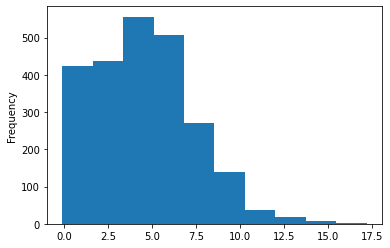

In [ ]:
train['signal_to_noise'].plot.hist();